In [160]:
import librosa
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns

In [161]:
# read out directories
data_path = Path("./data", "genres")
items = data_path.iterdir()
items = list(filter(lambda x: x.is_dir(), items)) # only directories of genres
#items = list(filter(lambda x: "pop" in str(x), items)) # only directories of genres

In [162]:
cols = [
    "name",
    "chroma_stft_mean",
    "bpm_mean",
    "spectral_centroid_mean",
    "rolloff",
    "zero_crossing_rate_mean",
    "harmony_mean",
    "perceptr_mean",
    "mfcc1_mean",
    "mfcc2_mean",
    "mfcc3_mean",
    "mfcc4_mean",
    "mfcc5_mean",
    "mfcc6_mean",
    "mfcc7_mean",
    "mfcc8_mean",
    "mfcc9_mean",
    "mfcc10_mean",
    "mfcc11_mean",
    "mfcc12_mean",
    "mfcc13_mean",
    "mfcc14_mean",
    "mfcc15_mean",
    "mfcc16_mean",
    "mfcc17_mean",
    "mfcc18_mean",
    "mfcc19_mean",
    "mfcc20_mean",
    "label"
]


Feature extraction functions

In [163]:
def zero_crossing_rate(audio_file):
    zero_crossings = librosa.zero_crossings(y=audio_file, pad=False)
    return np.mean(zero_crossings)

In [164]:
def harmonics(audio_file):
    y_harm, y_perc = librosa.effects.hpss(y=audio_file)
    return np.mean(y_harm), np.mean(y_perc)

In [165]:
def get_bpm(y, sr):
    tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
    return tempo

In [166]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

In [167]:
def spectral_centroid(audio_file, sr):
    centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)[0]
    return np.mean(normalize(centroids))


In [168]:
def spectral_rolloff(audio_file, sr):
    rolloff = librosa.feature.spectral_rolloff(y=audio_file, sr=sr)[0]
    return np.mean(normalize(rolloff))

In [169]:
def mfccs_list(audio_file, sr):
    mfccs_raw = librosa.feature.mfcc(y=audio_file, sr=sr)
    mfccs = np.mean(mfccs_raw, axis=1)
    return mfccs.tolist()

In [170]:
def chroma(audio_file, sr, hop_length=5000):
    # Increase or decrease hop_length to change how granular you want your data to be

    # Chromogram
    chromagram = librosa.feature.chroma_stft(y=audio_file, sr=sr, hop_length=hop_length)
    return np.mean(chromagram)


In [171]:
def extract_features(genres):
    df = pd.DataFrame(columns=cols)

    for genre in genres:
        name = str(genre).split("/")[-1]
        for audio_file in genre.iterdir():
            file_name = str(audio_file).split("/")[-1]

            # pressure strengths (y) and sample rate (sr)
            y, sr = librosa.load(audio_file)
            # Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
            audio_file, _ = librosa.effects.trim(y)

            # features
            zcr = zero_crossing_rate(audio_file)
            harm, perc = harmonics(audio_file)
            bpm = get_bpm(audio_file, sr)
            spec_centr = spectral_centroid(audio_file, sr)
            spec_roll = spectral_rolloff(audio_file, sr)
            mfccs = mfccs_list(audio_file, sr)
            chroma_freq = chroma(audio_file, sr)

            # append to df in column order
            row = [
                file_name,
                chroma_freq,
                bpm,
                spec_centr,
                spec_roll,
                zcr,
                harm,
                perc,
                *mfccs,
                name,
            ]
            df.loc[len(df)] = row

    return df


In [172]:
df = extract_features(items)

In [174]:
df.to_csv("data/features.csv")

In [176]:
df

,name,chroma_stft_mean,bpm_mean,spectral_centroid_mean,rolloff,zero_crossing_rate_mean,harmony_mean,perceptr_mean,mfcc1_mean,mfcc2_mean,...,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,label
0,hiphop.00023.wav,0.390503,92.285156,0.326896,0.407985,0.106795,-1.551194e-05,-0.000355,-44.723370,101.193695,...,8.381841,-15.426938,4.878397,-10.051116,4.564088,-1.991847,7.979235,1.212326,1.365209,hiphop
1,hiphop.00005.wav,0.500908,71.777344,0.484995,0.603603,0.124813,-2.844860e-04,-0.002899,-11.706974,81.976662,...,14.002207,-8.072070,7.428148,-5.495323,12.837337,-3.695439,6.218712,-2.584942,0.102165,hiphop
2,hiphop.00038.wav,0.427645,184.570312,0.468608,0.515060,0.105351,1.348090e-03,-0.003059,-27.395569,78.235847,...,-0.473602,-0.853041,-1.762178,-0.080440,3.510901,0.747590,1.177753,-1.213256,-3.546965,hiphop
3,hiphop.00089.wav,0.485283,123.046875,0.424295,0.494952,0.117709,-2.136740e-05,-0.000635,-103.145782,74.096313,...,17.616529,-0.035863,14.716657,-4.235781,10.654611,-6.327601,1.040412,-1.825620,5.556780,hiphop
4,hiphop.00011.wav,0.457304,135.999178,0.255831,0.497293,0.094250,-3.734742e-05,-0.001135,-74.213852,104.603294,...,6.884745,-15.329198,4.779245,-11.102331,4.739863,-2.809381,6.800127,-5.809848,-3.773828,hiphop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,reggae.00077.wav,0.403971,143.554688,0.316023,0.399653,0.060978,5.113971e-06,-0.000016,-151.813171,105.130333,...,-0.217455,-0.637148,-4.029582,-1.717147,-0.660766,-6.971738,-2.429490,-1.179267,-3.808237,reggae
996,reggae.00088.wav,0.382947,107.666016,0.327370,0.603316,0.189495,-8.231066e-07,0.000002,-75.256088,44.865067,...,-2.309444,-0.065276,-3.478622,-0.371196,-2.727345,2.511564,-0.981359,3.639063,-2.593978,reggae
997,reggae.00061.wav,0.392068,92.285156,0.369275,0.559322,0.133775,-1.469065e-06,-0.000083,-74.106682,57.996204,...,-1.561877,0.884449,1.031966,-4.334434,-3.753367,-3.667879,-1.059572,-4.109568,-4.135316,reggae
998,reggae.00009.wav,0.390330,161.499023,0.236925,0.380005,0.060649,-1.528642e-06,-0.000018,-232.504730,131.229507,...,8.022548,-3.781606,3.111249,-1.406352,3.267216,-4.095124,2.942163,0.397141,0.019509,reggae


Feature correlation heatmap

/tmp/ipykernel_22343/3884844893.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5]),
 [Text(0.5, 0, 'chroma_stft_mean'),
  Text(1.5, 0, 'bpm_mean'),
  Text(2.5, 0, 'spectral_centroid_mean'),
  Text(3.5, 0, 'zero_crossing_rate_mean'),
  Text(4.5, 0, 'harmony_mean'),
  Text(5.5, 0, 'perceptr_mean'),
  Text(6.5, 0, 'mfcc1_mean'),
  Text(7.5, 0, 'mfcc2_mean'),
  Text(8.5, 0, 'mfcc3_mean'),
  Text(9.5, 0, 'mfcc4_mean'),
  Text(10.5, 0, 'mfcc5_mean'),
  Text(11.5, 0, 'mfcc6_mean'),
  Text(12.5, 0, 'mfcc7_mean'),
  Text(13.5, 0, 'mfcc8_mean'),
  Text(14.5, 0, 'mfcc9_mean'),
  Text(15.5, 0, 'mfcc10_mean'),
  Text(16.5, 0, 'mfcc11_mean'),
  Text(17.5, 0, 'mfcc12_mean'),
  Text(18.5, 0, 'mfcc13_mean'),
  Text(19.5, 0, 'mfcc14_mean'),
  Text(20.5, 0, 'mfcc15_mean'),
  Text(21.5, 0, 'mfcc16_mean'),
  Text(22.5, 0, 'mfcc17_mean'),
  Text(23.5, 0, 'mfcc18_mean'),
  Text(24.5, 0, 'mfcc19_mean'),
  Text(25

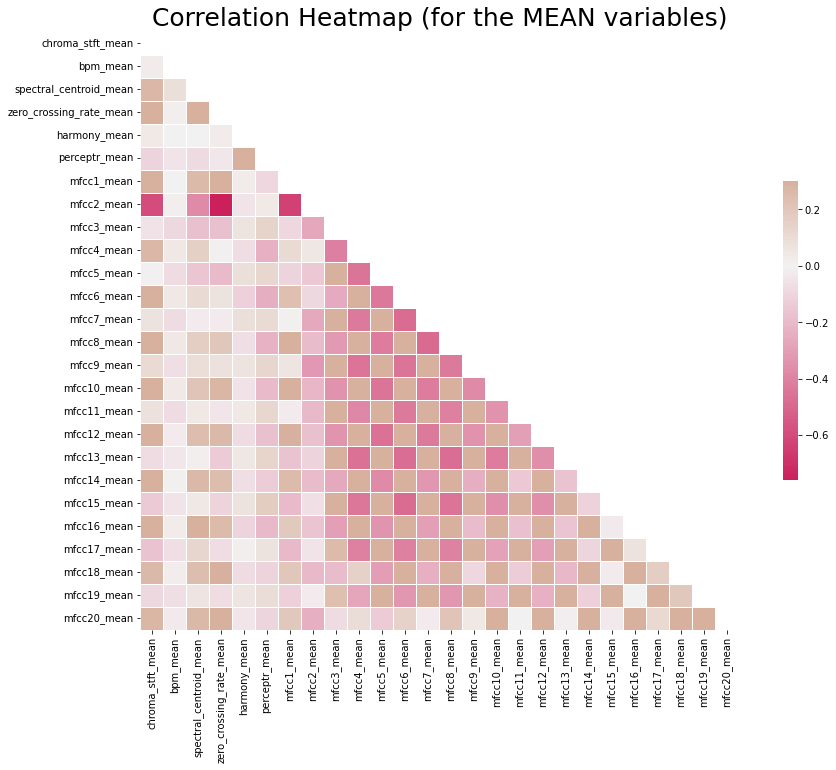

In [177]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)

Box plot for genre distributions

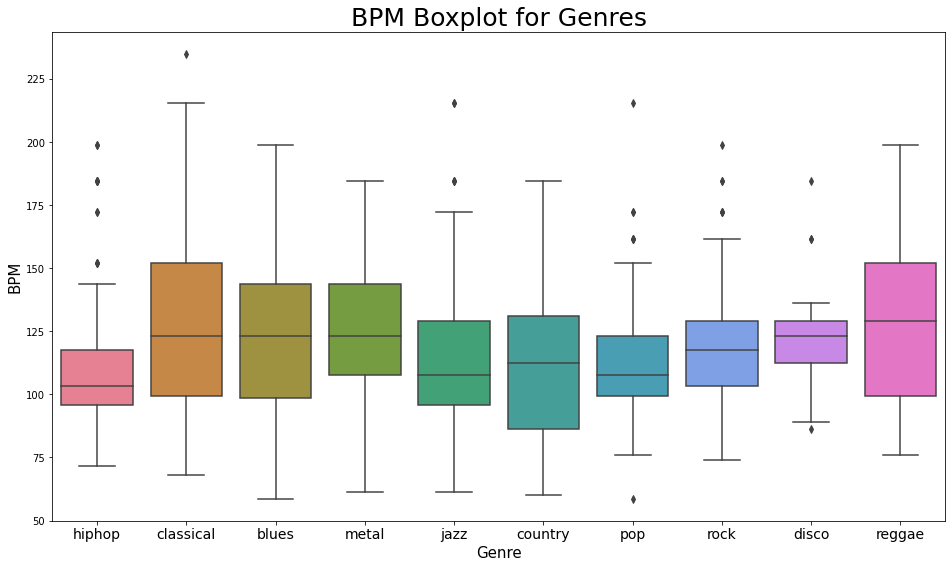

In [178]:
x = df[["label", "bpm_mean"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "bpm_mean", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.show()

Principal component analysis

In [179]:
from sklearn import preprocessing

df = df.iloc[0:, 1:]
y = df['label']
X = df.loc[:, df.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

array([0.35374079, 0.18932878])

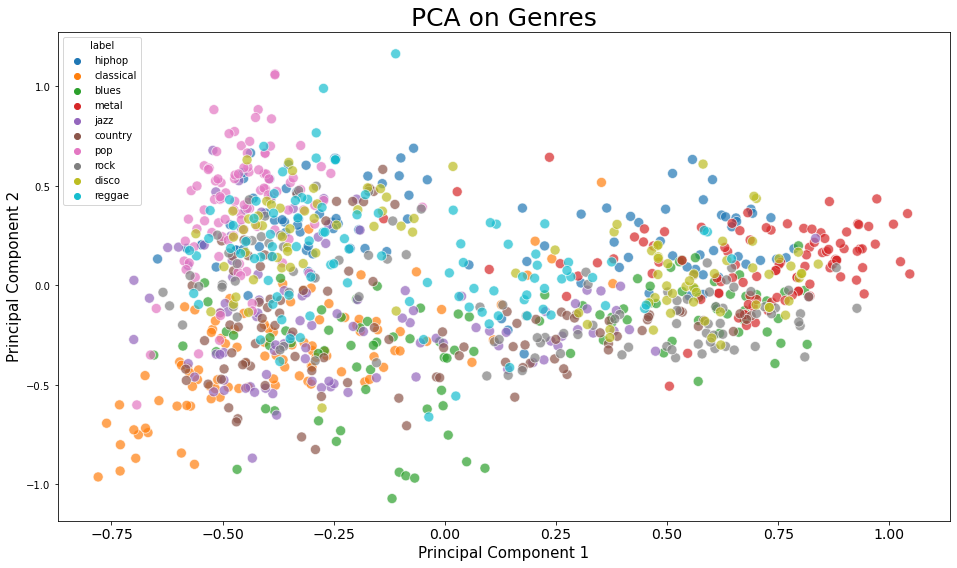

In [180]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100)
plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.show()